In [1]:
## import datetime
from IPython.display import display
import itertools
# from functools import lru_cache
import concurrent.futures
from matplotlib import pyplot as plt
import multiprocessing
import numpy as np
import pandas as pd
import random
from scipy.optimize import least_squares, minimize
from scipy import linalg
import statistics as stats
import time
import warnings
warnings.filterwarnings('ignore')


# matrix helpers
# @lru_cache(maxsize=126)
def _yi(price_series):
    return [np.log(p) for p in price_series]

# @lru_cache(maxsize=126)
def _fi(tc, m, time_series):
    return [np.power((tc - t), m) if str(np.power((tc - t), m)) != 'nan' else 0 for t in time_series]

# @lru_cache(maxsize=126)
def _gi(tc, m, w, time_series):
    return [np.power((tc - t), m) * np.cos(w * np.log(tc - t)) if str(np.power((tc - t), m) * np.cos(w * np.log(tc - t))) != 'nan' else 0 for t in time_series]

# @lru_cache(maxsize=126)
def _hi(tc, m, w, time_series):
    return [np.power((tc - t), m) * np.sin(w * np.log(tc - t)) if str(np.power((tc - t), m) * np.sin(w * np.log(tc - t))) != 'nan' else 0 for t in time_series]

# @lru_cache(maxsize=126)
def _fi_pow_2(tc, m, time_series):
    return np.power(_fi(tc, m, time_series), 2)

# @lru_cache(maxsize=126)
def _gi_pow_2(tc, m, w, time_series):
    return np.power(_gi(tc, m, w, time_series), 2)

# @lru_cache(maxsize=126)
def _hi_pow_2(tc, m, w, time_series):
    return np.power(_hi(tc, m, w, time_series), 2)

# @lru_cache(maxsize=126)
def _figi(tc, m, w, time_series):
    return np.multiply(_fi(tc, m, time_series), _gi(tc, m, w, time_series))

# @lru_cache(maxsize=126)
def _fihi(tc, m, w, time_series):
    return np.multiply(_fi(tc, m, time_series), _hi(tc, m, w, time_series))

# @lru_cache(maxsize=126)
def _gihi(tc, m, w, time_series):
    return np.multiply(_gi(tc, m, w, time_series), _hi(tc, m, w, time_series))

# @lru_cache(maxsize=126)
def _yifi(tc, m, time_series, price_series):
    return np.multiply(_yi(price_series), _fi(tc, m, time_series))

# @lru_cache(maxsize=126)
def _yigi(tc, m, w, time_series, price_series):
    return np.multiply(_yi(price_series), _gi(tc, m, w, time_series))

# @lru_cache(maxsize=126)
def _yihi(tc, m, w, time_series, price_series):
    return np.multiply(_yi(price_series), _hi(tc, m, w, time_series))


In [7]:
# revised version of the LPPL without φ
# found on page 11 as equation (13)
def lppl(t, tc, m, w, a, b, c1, c2):
    return a + np.power(tc - t, m) * (b + ((c1 * np.cos(w * np.log(tc - t))) + (c2 * np.sin(w * np.log(tc - t)))))

# finds the least square difference
def func_restricted(x, *args):
    
    tc = x[0]
    m  = x[1]
    w  = x[2]
    
    data_series = args[0]
#     melt = args[1]
    melt = get_melt(data_series, tc, m, w)
       
    # lin_vals = matrix_equation(tc, m, w, data_series)
    lin_vals = mef(melt)

    a  = lin_vals[0] 
    b  = lin_vals[1]
    c1 = lin_vals[2] 
    c2 = lin_vals[3]

    delta = [lppl(t, tc, m, w, a, b, c1, c2) for t in data_series[0]]
    delta = np.subtract(delta, data_series[1])
    delta = np.power(delta, 2)
    return np.sum(delta)

# solve the matrix equation (fast)
def mef(melt):
    N  = len(melt)
    fi = sum(melt['_fi'])
    gi = sum(melt['_gi'])
    hi = sum(melt['_hi'])
    fi_pow_2 = sum(melt['_fi_pow_2'])
    gi_pow_2 = sum(melt['_gi_pow_2'])
    hi_pow_2= sum(melt['_hi_pow_2'])
    figi = sum(melt['_figi'])
    fihi = sum(melt['_fihi'])
    gihi = sum(melt['_gihi'])
    yi = sum(melt['_yi'])
    yifi = sum(melt['_yifi'])
    yigi = sum(melt['_yigi'])
    yihi = sum(melt['_yihi'])

    matrix_1 = np.matrix([
        [N,  fi,       gi,       hi      ],
        [fi, fi_pow_2, figi,     fihi    ],
        [gi, figi,     gi_pow_2, gihi    ],
        [hi, fihi,     gihi,     hi_pow_2]
    ])
    
    matrix_2 = np.matrix([
        [yi],
        [yifi],
        [yigi],
        [yihi]
    ])

    try:
        product = linalg.solve(matrix_1, matrix_2)
        return [i[0] for i in product]

    except Exception as e:
        print(e)

# solve the matrix equation (slow)
def matrix_equation(tc, m, w, data_series):
    time_series = data_series[0]
    price_series = data_series[1]
    N  = len(price_series)
    
    #--------------------------------
    fi = sum(_fi(tc, m, time_series))
    gi = sum(_gi(tc, m, w, time_series))
    hi = sum(_hi(tc, m, w, time_series))

    #--------------------------------
    fi_pow_2 = sum(_fi_pow_2(tc, m, time_series))
    gi_pow_2 = sum(_gi_pow_2(tc, m, w, time_series))
    hi_pow_2= sum(_hi_pow_2(tc, m, w, time_series))

    #--------------------------------
    figi = sum(_figi(tc, m, w, time_series))
    fihi = sum(_fihi(tc, m, w, time_series))
    gihi = sum(_gihi(tc, m, w, time_series))

    #--------------------------------
    yi = sum(_yi(price_series))
    yifi = sum(_yifi(tc, m, time_series, price_series))
    yigi = sum(_yigi(tc, m, w, time_series, price_series))
    yihi = sum(_yihi(tc, m, w, time_series, price_series))
    
    #--------------------------------
    matrix_1 = np.matrix([
        [N,  fi,       gi,       hi      ],
        [fi, fi_pow_2, figi,     fihi    ],
        [gi, figi,     gi_pow_2, gihi    ],
        [hi, fihi,     gihi,     hi_pow_2]
    ])
    
    matrix_2 = np.matrix([
        [yi],
        [yifi],
        [yigi],
        [yihi]
    ])

    try:
        product = linalg.solve(matrix_1, matrix_2)
        return [i[0] for i in product]

    except Exception as e:
        print(e)

# def calc_lppls_confidence(symbol, ds_lppls_confidence_fits):
#     true_count = 0
#     total_count = len(ds_lppls_confidence_fits)
#     for i in ds_lppls_confidence_fits:
#         if i[symbol]['ds_lppls_confidence'] == True:
#             true_count = true_count + 1
            
#     print('{}/{}={}'.format(true_count, total_count, true_count/total_count))
#     return true_count/total_count


def get_melt(data_series, tc, m, w):

    time_series = data_series[0]
    price_series = data_series[1]
    
    melt = pd.DataFrame({})
    melt['price_series'] = price_series
    melt['time_series'] = time_series
    melt['_yi'] = [np.log(p) for p in melt['price_series']]
    melt['_fi'] = [np.power((tc - t), m) if str(np.power((tc - t), m)) != 'nan' else 0 for t in melt['time_series']]
    melt['_gi'] = [np.power((tc - t), m) * np.cos(w * np.log(tc - t)) if str(np.power((tc - t), m) * np.cos(w * np.log(tc - t))) != 'nan' else 0 for t in melt['time_series']]
    melt['_hi'] = [np.power((tc - t), m) * np.sin(w * np.log(tc - t)) if str(np.power((tc - t), m) * np.sin(w * np.log(tc - t))) != 'nan' else 0 for t in melt['time_series']]
    melt['_fi_pow_2'] = np.power(melt['_fi'], 2)
    melt['_gi_pow_2'] = np.power(melt['_gi'], 2)
    melt['_hi_pow_2'] = np.power(melt['_hi'], 2)
    melt['_figi'] = np.multiply(melt['_fi'], melt['_gi'])
    melt['_fihi'] = np.multiply(melt['_fi'], melt['_hi'])
    melt['_gihi'] = np.multiply(melt['_gi'], melt['_hi'])
    melt['_yifi'] = np.multiply(melt['_yi'], melt['_fi'])
    melt['_yigi'] = np.multiply(melt['_yi'], melt['_gi'])
    melt['_yihi'] = np.multiply(melt['_yi'], melt['_hi'])
    
    return melt

        
"""
upperbound = 126 # ~6 months (in trading days)
lowerbound = 21 # ~1 month (in trading days)
interval = 5
"""       
def compute_ds_lppls_confidence(args):
    
    df, symbol, upperbound, lowerbound, interval = args
    
    df2 = pd.DataFrame(df)
    
    ds_lppls = []
    
    number_of_fitting_windows = int((upperbound - lowerbound)/interval)
    
    for i in range(number_of_fitting_windows):

        tLen = upperbound-(i*interval)
        tradings_days_data = df.tail(tLen)
        time = np.linspace(0, tLen-1, tLen)
        price = np.array([tradings_days_data[i] for i in range(len(tradings_days_data))])
        data_series = np.array([time, price])

        # print(tradings_days_data)
        
        MAX_SEARCHES = 5
        SEARCH_COUNT = 0
        
        # set limits for non-linear params
        bounds = [
            (tLen-(tLen*0.2), tLen+(tLen*0.2)),    # Critical Time + or - .2
            (0.1, 0.9),                            # m : 0.1 ≤ m ≤ 0.9
            (6, 13),                               # ω : 6 ≤ ω ≤ 13     
        ]

        # find bubbles
        while SEARCH_COUNT < MAX_SEARCHES:

            # randomly choose vals for non-linear params 
            non_lin_vals = [random.uniform(a[0], a[1]) for a in bounds]

            tc = non_lin_vals[0]
            m  = non_lin_vals[1] 
            w  = non_lin_vals[2]

            # params to pass to scipy.optimize
            seed = np.array([tc, m, w])
            
#             melt = get_melt(data_series, tc, m, w)
            # print(melt)
            
            # scipy optimize minimize
            try:
                # Nelder-Mead
                cofs = minimize(
                    args=(data_series), 
                    fun=func_restricted, 
                    method='Nelder-Mead', 
#                     options={
#                         'adaptive': True
#                     },
                    x0=seed
                )
                
                if cofs.success:
#                     print('minimize ran succsessfully in {} search(es)'.format(SEARCH_COUNT+1))
                    # determine if it falls in range:

                    _tc = cofs.x[0]
                    _m =  cofs.x[1]
                    _w =  cofs.x[2]
                                    
                    # calculate the linear vals again...
#                     lin_vals = matrix_equation(tc, m, w, data_series)
                    _melt = get_melt(data_series, _tc, _m, _w)
                    _lin_vals = mef(_melt)

                    a  = _lin_vals[0] 
                    b  = _lin_vals[1]
                    c1 = _lin_vals[2] 
                    c2 = _lin_vals[3]
                    
#                     print(_tc,_m,_w,a,b,c1,c2)
                    
                    # filtering conditions 
                    tc_in_range   = tLen-(tLen*0.05) < _tc < tLen+(tLen*0.1)
                    m_in_range    = 0.01 < _m < 1.2
                    w_in_range    = 2 < _w < 25
                    n_oscillation = ((_w/2)*np.log(abs((_tc - (i*5))/(tLen)))) > 2.5
                    # for bubble end flag
                    damping_bef   = (_m*abs(b))/(_w*abs(c1+c2)) > 0.8 
                    # for bubble early warning 
                    damping_bew   = (_m*abs(b))/(_w*abs(c1+c2)) > 0.0 

                    if (tc_in_range and m_in_range and w_in_range and n_oscillation and damping_bef):
                        ds_lppls_confidence_bef = True
                    else: 
                        ds_lppls_confidence_bef = False
                        
                    if (tc_in_range and m_in_range and w_in_range and n_oscillation and damping_bew):
                        ds_lppls_confidence_bew = True
                    else: 
                        ds_lppls_confidence_bew = False   

                    ds_lppls.append({symbol: {
                        'ds_lppls_confidence_bef': ds_lppls_confidence_bef,
                        'ds_lppls_confidence_bew': ds_lppls_confidence_bew,
                        'cof': cofs.x,
                    }})
                    break

                else:
                    SEARCH_COUNT = SEARCH_COUNT + 1
#                     print('minimize failed to find a solution, trying again')
                    
            except Exception as e:
#                 print('minimize failed: {}'.format(e))
                SEARCH_COUNT = SEARCH_COUNT + 1
                
        if SEARCH_COUNT >= MAX_SEARCHES:
            # no solution found in 5 tries, so just add this and move one
#             print('minimize failed in allotted attempts (5)')
            ds_lppls.append({symbol: {
                'ds_lppls_confidence_bef': False,
                'ds_lppls_confidence_bew': False,
                'cof': None,
                'max_searches_exceeded': True
            }})
    
    # calculate the actual ds lppls confidence value for end flag and early warning
    true_count_bef = 0
    true_count_bew = 0
    total_count = len(ds_lppls)
    for i in ds_lppls:
        if i[symbol]['ds_lppls_confidence_bef'] == True:
            true_count_bef = true_count_bef + 1
        if i[symbol]['ds_lppls_confidence_bew'] == True:
            true_count_bew = true_count_bew + 1   
            
    ds_lppls_confidence_bef_val = true_count_bef/total_count
    ds_lppls_confidence_bew_val = true_count_bew/total_count
    
    # find the sign of the median of cumulative returns since the time t1
    df2['ret']  = (df2[symbol]/df2[symbol].shift(1))-1
    df2['cum_ret'] = df2['ret'].cumsum()
#     print(df2.head())
    median = stats.median(df2['cum_ret'].tolist())
#     print('median: {}'.format(median))
    median_sign = 1 if median > 0 else -1
#     print('median_sign: {}'.format(median_sign))
    
    return {
        'val_bef': ds_lppls_confidence_bef_val * median_sign,
        'val_bew': ds_lppls_confidence_bew_val * median_sign,
        'date': df.tail(1).index.tolist()[0],
        'price': df.tail(1).tolist()[0]
    }

In [9]:
data = pd.read_csv("../data/backtest-2.csv", index_col="date")
data.fillna(method='ffill')

master_data_len = len(data)
window_len = 126
ground_to_cover = master_data_len-window_len

# symbols = ['MU', 'ALK', 'MCK', 'FOX', 'NWSA', 'CVX', 'MGM', 'AMZN', 'O', 'TAP', 'CLX', 'HD', 'CME', 'UHS', 'STI', 'LMT', 'PEP', 'GS', 'OMC', 'GM', 'NDAQ', 'SYY', 'KMI', 'CNC', 'DAL', 'D', 'EVRG', 'KEYS', 'ORCL', 'PBCT', 'CTL', 'PKI', 'PLD', 'KIM', 'NEM', 'SLB', 'TTWO', 'TFX', 'EXPE', 'SCHW', 'AWK', 'ZION', 'GD', 'TSS', 'INCY', 'IRM', 'CINF', 'PFE', 'BWA', 'CERN', 'PEG', 'RTN', 'FTI', 'TPR', 'TXN', 'APD', 'WU', 'NBL', 'BEN', 'UTX', 'WELL', 'A', 'CCL', 'AIZ', 'DIS', 'AXP', 'PWR', 'ROL', 'SNPS', 'TRV', 'AMG', 'ECL', 'MO', 'CAH', 'BLL', 'ADM', 'IEX', 'IQV', 'HCP', 'K', 'JKHY', 'TMUS', 'IT', 'NEE', 'STX', 'MYL', 'GRMN', 'ADSK', 'DISCK', 'ALLE', 'LDOS', 'HPE', 'FDX', 'ALXN', 'RMD', 'SPGI', 'UNH', 'HIG', 'TGT']
symbols = ['MU']

for symbol in symbols:    

    start = time.time()
    
    #--- Multiprocessing approach ---#
#     workers = 8 # 12 locked-up your macbook bro
#     pool = multiprocessing.Pool(processes=workers)
#     # compute the ds_lppls_confidence for shrinking windows
#     result = pool.map(compute_ds_lppls_confidence, [(data[symbol].iloc[i:window_len+i], symbol, 126, 21, 5) for i in range(ground_to_cover)])
#     pool.close()
    #--- ------------------------ ---#
    
    result = []
#     for i in range(ground_to_cover):
    for i in range(5):
        result.append(compute_ds_lppls_confidence((data[symbol].iloc[i:window_len+i], symbol, 126, 21, 5)))
        print(result)
        
    print(data[symbol])
    end = time.time()
    duration_of_fit = end - start
    print(duration_of_fit) 
    print(result)
    print('------------')
    
    d = result

    price = [p['price'] for p in d]
    val_bef = [v['val_bef'] for v in d]
    val_bew = [v['val_bew'] for v in d]
    t = [t['date'] for t in d]

#     df_to_csv = pd.DataFrame({'date':t, 'price':price, 'val_bef': val_bef, 'val_bew': val_bew})
#     df_to_csv.to_csv('/Users/joshnielsen/Desktop/{}_with_mef.csv'.format(symbol.lower()))

Matrix is singular.
array must not contain infs or NaNs
array must not contain infs or NaNs
Matrix is singular.
Matrix is singular.
[{'val_bef': -0.0, 'val_bew': -0.047619047619047616, 'date': '2018-09-07', 'price': 44.86}]
array must not contain infs or NaNs
array must not contain infs or NaNs
Matrix is singular.
Matrix is singular.
[{'val_bef': -0.0, 'val_bew': -0.047619047619047616, 'date': '2018-09-07', 'price': 44.86}, {'val_bef': -0.0, 'val_bew': -0.0, 'date': '2018-09-10', 'price': 44.9}]
array must not contain infs or NaNs
array must not contain infs or NaNs
[{'val_bef': -0.0, 'val_bew': -0.047619047619047616, 'date': '2018-09-07', 'price': 44.86}, {'val_bef': -0.0, 'val_bew': -0.0, 'date': '2018-09-10', 'price': 44.9}, {'val_bef': -0.0, 'val_bew': -0.0, 'date': '2018-09-11', 'price': 43.6}]


KeyboardInterrupt: 

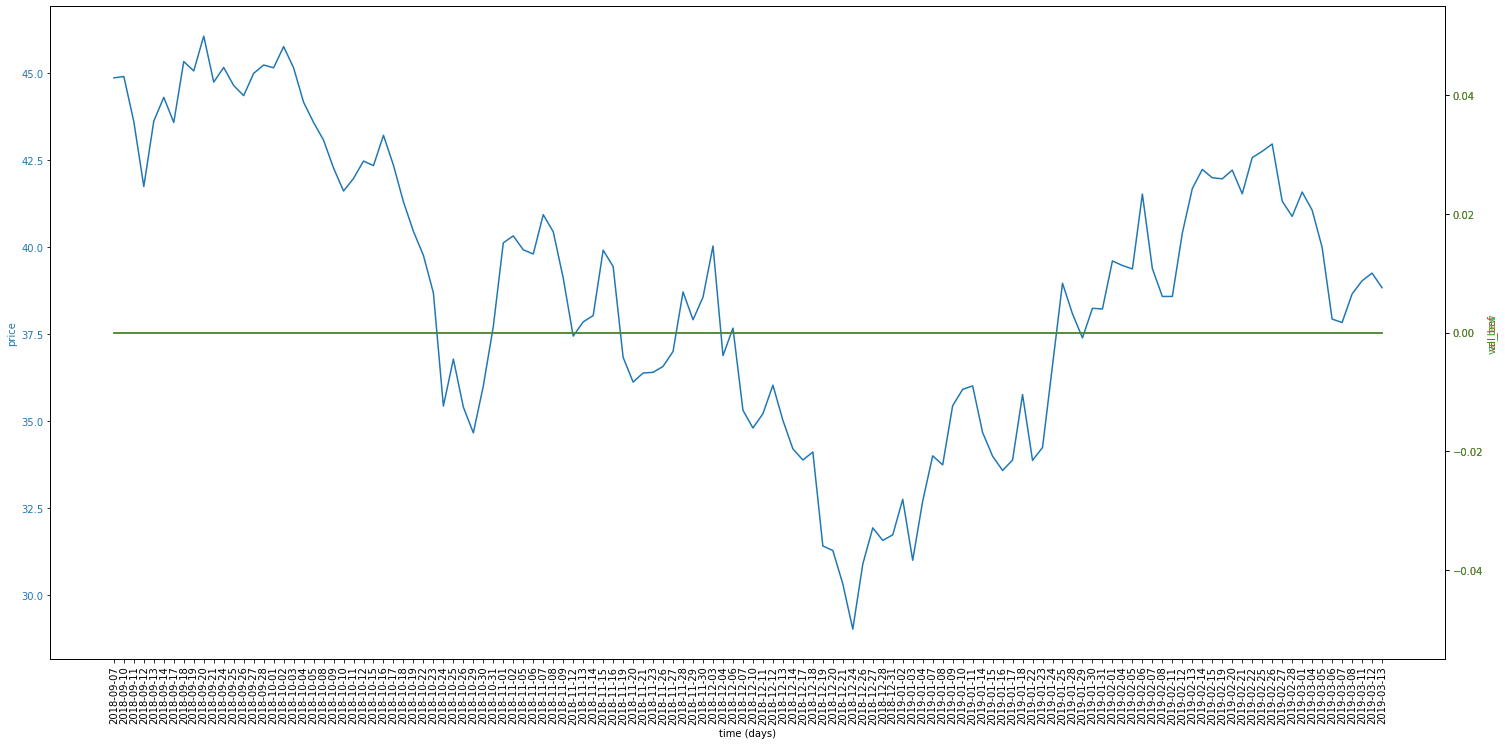

In [10]:
#plot the confidence indicators
fig, ax1 = plt.subplots(figsize=(25,12))

plt.xticks(rotation=90)

color = 'tab:blue'
ax1.set_xlabel('time (days)')
ax1.set_ylabel('price', color=color)
ax1.plot(t, price, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('val_bef', color=color)  # we already handled the x-label with ax1
ax2.plot(t, val_bef, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax3.set_ylabel('val_bew', color=color)  # we already handled the x-label with ax1
ax3.plot(t, val_bew, color=color)
ax3.tick_params(axis='y', labelcolor=color)